<span style="color:green">
    <ul><b>
    <li>Developer: Andrew Okafor, Ph.D.</li>
    <li>Project Start Date (Challenge Received): November 26 @ 12:05 pm ET</li>
    <li>Project End Date (Last Modified): November 29 @ 12:00 pm ET (noon)</li>
    <li>Client end point: <a href=http://54.175.103.141:8503 target="_blank">link to app</a> </li>
    </ul></b>
</span>

<ul>
<li>Developer: Andrew Okafor, Ph.D.</li>
<li>Project Start Date (Challenge Received): November 26 @ 12:05 pm ET</li>
<li>Project End Date (Last Modified): November 29 @ 12:00 pm ET (noon)</li>
<li>Client end point: <a href="http://54.175.103.141:8503" target="_blank">link to app</a></li>
</ul>


<h1 style="color:green" align="center"> Classification Model Pipeline</h1>

<h3 style="color:blue">Introduction</h3>
<h5>This is a semi-supervised learning problem where a client has provided us with labeled data and wishes to make predictions on an unlabeled dataset, specifically to identify which data points are considered outliers (i.e., which data falls outside the class of known labels). Here, we are given a dataset of MIDI files labeled with composers and an additional set of unlabeled MIDI files. The task is to determine which of the unlabeled files do not belong to the known classes of composers.</h5>


<h4 style="color:blue">Objective/Goal</h4>
<h5>The goal is to develop a machine learning (ML) model to detect MIDI files composed by someone other than Bach, Beethoven, Brahms, or Schubert.</h5>


<h4 style="color:blue">Summary</h4>
<h5>
    Firstly, I extracted musical features from the MIDI files using the <b>music21</b> library in Python. The features include:
    <ul>
        <li>Key features: key name, key quality/mode, key signature, etc.</li>
        <li>Pitch features: pitch distribution, note pitch, average chord pitch, etc.</li>
        <li>Rhythmic features: note durations, etc.</li>
        <li>Harmonic features: chords, chord progressions, etc.</li>
    </ul>
    With these features, I built a robust machine learning classification model to classify the labeled MIDI files. The process involved:
    <ul>
        <li>Importing the relevant libraries.</li>
        <li>Data cleaning and preparation. </li>
        <li>Exploratory data analysis.</li>
        <li>Data preprocessing.</li>
        <li>Model selection, feature engineering and hyperparameter optimization.</li>
        <li>Model re-training, inference, evaluation and saving.</li>
        <li>Model performance metrics.</li>
        <li>Model deployment for end-user client.</li>
    </ul>
    Using this robust model, I was able to classify the unlabeled data by predicting the likelihood of each MIDI file belonging to one of the known composers. Files with low likelihood scores were flagged as potential outliers, representing works from composers other than Bach, Beethoven, Brahms, or Schubert.
</h5>

<h2 style="color:blue">1. Importing the Necessary Libraries</h2>
<h5>I have prepared some custom functions in ../src/utils.py<br>
    Model and Hypaparamter search space is stored in ../src/utils/search_space_config.py
</h5>

In [132]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
import shap
import joblib
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import sys
sys.path.append('../')

## importing custom functions from src/utils.py
from src.utils import remove_correlated_features
from src.utils import plot_correlation_heatmap
from src.utils import remove_low_variance_features
from src.utils import plot_pca
from src.utils import plot_feature_importances
from src.utils import confusion_matrix_heatmap
from src.search_space_config import create_search_space
from src.utils import extract_features_from_mdi
from src.utils import preprocess_inference_data

<ul style="color:red">
    <li>Here, I have prepared a function in ../src/utils.py to extract metadata from the audio file.</li>
    <li>This extracted data would be saved as a csv file in ../data/processed/ for downstream useage in the pipeline.</li>
</ul>

In [54]:
# Process MIDI files and extract features
processed_data = pd.DataFrame()
for composer in ['Bach','Beethoven','Brahms','Schubert']:
    processed_data = pd.concat([processed_data, extract_features_from_mdi(f'../data/raw/Part1(PS1)/{composer}/', composer)], ignore_index=True)
# save processed data to csv
processed_data.to_csv('../data/processed/processed_data.csv', index=False)

Error processing ../data/raw/Part1(PS1)/Beethoven\Piano Sonata No 17 in D minor_OP31NO2_2391_ps17_01.mid: 2612104032368
Error processing ../data/raw/Part1(PS1)/Beethoven\Piano Sonata No 5 in C minor_OP10NO1_2529_ps05_03.mid: 2612110927616
Error processing ../data/raw/Part1(PS1)/Beethoven\Piano Sonata No 9 in E major_OP14NO1_2371_ps09_02.mid: 2612113675216
Error processing ../data/raw/Part1(PS1)/Beethoven\String Quartet No 12 in E-flat major_OP127_2365_qt12_1.mid: 2612064203200
Error processing ../data/raw/Part1(PS1)/Beethoven\String Quartet No 7 in F major_OP59NO1_2621_qt07_1.mid: 2612131323136
Error analyzing key for ../data/raw/Part1(PS1)/Brahms\Clarinet Sonata No 1 in F minor_OP120NO1_2116_brahms_sonata_opus_120-1.mid: 'Unpitched' object has no attribute 'pitch'
Error analyzing key for ../data/raw/Part1(PS1)/Brahms\Clarinet Sonata No 1 in F minor_OP120NO1_2118_brahms_sonata_opus_120-3.mid: 'Unpitched' object has no attribute 'pitch'
Error analyzing key for ../data/raw/Part1(PS1)/Bra

<ul style="color:red">
    <li>The error messages produced above indicates that those mid files are corrupt, they are either unreadable or contain no musical element (no sound).</li>
    <li>I implemented the "extract_features_from_mdi" function to catch the errors during feature extraction.</li>
</ul>

<h2 style="color:blue">2. Data Cleaning and Preparation</h2>

In this section, I will try to clean up and prepare the dataset for downstream preprocessing. This section will include:
<ul>
    <li>Loading the data from the data folder</li>
    <li>Checking for missing values or empty cells</li>
    <li>Performing imputation on missing values (or empty cells) if present</li>
    <li>Handling of categorical variables with one-hot encoding or label-encoding, if present</li>
    <li>Removing highly correlated variables (features) </li>
</ul>

In [107]:
processed_data = pd.read_csv('../data/processed/processed_data.csv')
processed_data

,key_name,key_mode,key_strength,num_key_signature_changes,most_frequent_key_signature,average_pitch,median_pitch,std_dev_pitch,pitch_range,unique_pitch_classes,...,most_common_instrument,average_tempo,min_tempo,max_tempo,tempo_variability,time_signature_changes,most_frequent_time_signature,measure_count,total_duration,composer
0,C,major,0.883717,4,0.0,52.871897,53.0,6.164130,31.0,12,...,--------------------------------------,52.500000,35.0,70.0,17.500000,4,3/4,0,264.0,Bach
1,C,major,0.886779,4,0.0,52.956790,53.0,6.183093,31.0,11,...,--------------------------------------,150.000000,50.0,250.0,100.000000,4,4/4,0,196.0,Bach
2,A,minor,0.877006,4,0.0,52.731313,53.0,6.011649,28.0,12,...,--------------------------------------,202.500000,155.0,250.0,47.500000,4,3/4,0,507.0,Bach
3,C,major,0.876151,4,0.0,53.013825,54.0,6.446861,31.0,12,...,--------------------------------------,40.000000,40.0,40.0,0.000000,4,3/4,0,144.0,Bach
4,C,major,0.838132,9,0.0,54.097643,55.0,5.423326,29.0,11,...,--------------------------------------,158.333333,75.0,250.0,71.686044,3,4/4,0,532.0,Bach
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,D,major,0.811751,4,2.0,62.860843,64.0,13.709972,71.0,12,...,Instrument19,185.000000,168.0,202.0,17.000000,4,4/4,0,1458.0,Schubert
185,D,major,0.817013,12,2.0,62.413847,64.0,12.497622,60.0,12,...,Instrument19,167.563636,154.0,180.0,8.448267,176,3/4,0,1510.75,Schubert
186,E-,major,0.930132,12,-3.0,67.584334,67.0,10.366027,55.0,12,...,Instrument19,126.000000,110.0,138.0,13.856406,144,3/4,0,507.0,Schubert
187,B-,major,0.890524,5,-2.0,66.388654,67.0,12.710969,72.0,12,...,Staff-1,170.527778,130.0,218.0,17.944337,35,2/4,0,1618.25,Schubert


In [108]:
# check for missing values or empty cells
processed_data.isnull().sum()

key_name                         3
key_mode                         3
key_strength                     0
num_key_signature_changes        0
most_frequent_key_signature     16
average_pitch                    0
median_pitch                     0
std_dev_pitch                    0
pitch_range                      0
unique_pitch_classes             0
pitch_entropy                    0
average_melodic_interval         0
note_density                     0
rhythmic_variance                0
rest_proportion                  0
chord_diversity                  0
most_common_chord               11
consonance_ratio                 0
num_instruments                  0
instrument_diversity             0
most_common_instrument           0
average_tempo                    0
min_tempo                        0
max_tempo                        0
tempo_variability                0
time_signature_changes           0
most_frequent_time_signature     0
measure_count                    0
total_duration      

In [109]:
# columns with missing values
missing_columns = processed_data.columns[processed_data.isnull().any()].tolist()
missing_columns

['key_name', 'key_mode', 'most_frequent_key_signature', 'most_common_chord']

<ul style="color:red">
    <li>Dropping columns with high number of NAN values.</li>
    <li>Dropping "most_frequent_key_signature" and "most_common_chord" columns.</li>
</ul>

In [110]:
processed_data.drop(['most_frequent_key_signature','most_common_chord'], axis=1, inplace=True)
processed_data

,key_name,key_mode,key_strength,num_key_signature_changes,average_pitch,median_pitch,std_dev_pitch,pitch_range,unique_pitch_classes,pitch_entropy,...,most_common_instrument,average_tempo,min_tempo,max_tempo,tempo_variability,time_signature_changes,most_frequent_time_signature,measure_count,total_duration,composer
0,C,major,0.883717,4,52.871897,53.0,6.164130,31.0,12,3.134150,...,--------------------------------------,52.500000,35.0,70.0,17.500000,4,3/4,0,264.0,Bach
1,C,major,0.886779,4,52.956790,53.0,6.183093,31.0,11,3.075162,...,--------------------------------------,150.000000,50.0,250.0,100.000000,4,4/4,0,196.0,Bach
2,A,minor,0.877006,4,52.731313,53.0,6.011649,28.0,12,3.185360,...,--------------------------------------,202.500000,155.0,250.0,47.500000,4,3/4,0,507.0,Bach
3,C,major,0.876151,4,53.013825,54.0,6.446861,31.0,12,3.267104,...,--------------------------------------,40.000000,40.0,40.0,0.000000,4,3/4,0,144.0,Bach
4,C,major,0.838132,9,54.097643,55.0,5.423326,29.0,11,3.231178,...,--------------------------------------,158.333333,75.0,250.0,71.686044,3,4/4,0,532.0,Bach
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,D,major,0.811751,4,62.860843,64.0,13.709972,71.0,12,3.444292,...,Instrument19,185.000000,168.0,202.0,17.000000,4,4/4,0,1458.0,Schubert
185,D,major,0.817013,12,62.413847,64.0,12.497622,60.0,12,3.400973,...,Instrument19,167.563636,154.0,180.0,8.448267,176,3/4,0,1510.75,Schubert
186,E-,major,0.930132,12,67.584334,67.0,10.366027,55.0,12,3.135565,...,Instrument19,126.000000,110.0,138.0,13.856406,144,3/4,0,507.0,Schubert
187,B-,major,0.890524,5,66.388654,67.0,12.710969,72.0,12,3.322906,...,Staff-1,170.527778,130.0,218.0,17.944337,35,2/4,0,1618.25,Schubert


In [111]:
# rows with missing values
processed_data[processed_data.isnull().any(axis=1)]

,key_name,key_mode,key_strength,num_key_signature_changes,average_pitch,median_pitch,std_dev_pitch,pitch_range,unique_pitch_classes,pitch_entropy,...,most_common_instrument,average_tempo,min_tempo,max_tempo,tempo_variability,time_signature_changes,most_frequent_time_signature,measure_count,total_duration,composer
144,NaN,NaN,0.0,6,60.775749,61.0,12.467054,57.0,12,3.414932,...,No. 1,120.0,120.0,120.0,0.0,2,3/4,0,2152/3,Brahms
145,NaN,NaN,0.0,2,60.569524,61.0,12.578191,65.0,12,3.007152,...,grazioso,130.0,120.0,140.0,10.0,2,3/4,0,584.5,Brahms
146,NaN,NaN,0.0,2,62.545813,64.0,11.758678,69.0,12,3.200194,...,Opus 20,180.0,120.0,240.0,60.0,2,2/2,0,888.0,Brahms


<ul style="color:red">
    <li>Dropping rows (datapoints) which have no musical key elements (no key name, no key mode), because these are not sound.</li>
    <li>Dropping rows 144 to 146.</li>
</ul>

In [112]:
# drop the rows with missing values
processed_data.dropna(inplace=True)
processed_data.reset_index(drop=True, inplace=True)
processed_data

,key_name,key_mode,key_strength,num_key_signature_changes,average_pitch,median_pitch,std_dev_pitch,pitch_range,unique_pitch_classes,pitch_entropy,...,most_common_instrument,average_tempo,min_tempo,max_tempo,tempo_variability,time_signature_changes,most_frequent_time_signature,measure_count,total_duration,composer
0,C,major,0.883717,4,52.871897,53.0,6.164130,31.0,12,3.134150,...,--------------------------------------,52.500000,35.0,70.0,17.500000,4,3/4,0,264.0,Bach
1,C,major,0.886779,4,52.956790,53.0,6.183093,31.0,11,3.075162,...,--------------------------------------,150.000000,50.0,250.0,100.000000,4,4/4,0,196.0,Bach
2,A,minor,0.877006,4,52.731313,53.0,6.011649,28.0,12,3.185360,...,--------------------------------------,202.500000,155.0,250.0,47.500000,4,3/4,0,507.0,Bach
3,C,major,0.876151,4,53.013825,54.0,6.446861,31.0,12,3.267104,...,--------------------------------------,40.000000,40.0,40.0,0.000000,4,3/4,0,144.0,Bach
4,C,major,0.838132,9,54.097643,55.0,5.423326,29.0,11,3.231178,...,--------------------------------------,158.333333,75.0,250.0,71.686044,3,4/4,0,532.0,Bach
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,D,major,0.811751,4,62.860843,64.0,13.709972,71.0,12,3.444292,...,Instrument19,185.000000,168.0,202.0,17.000000,4,4/4,0,1458.0,Schubert
182,D,major,0.817013,12,62.413847,64.0,12.497622,60.0,12,3.400973,...,Instrument19,167.563636,154.0,180.0,8.448267,176,3/4,0,1510.75,Schubert
183,E-,major,0.930132,12,67.584334,67.0,10.366027,55.0,12,3.135565,...,Instrument19,126.000000,110.0,138.0,13.856406,144,3/4,0,507.0,Schubert
184,B-,major,0.890524,5,66.388654,67.0,12.710969,72.0,12,3.322906,...,Staff-1,170.527778,130.0,218.0,17.944337,35,2/4,0,1618.25,Schubert


In [113]:
# confirm no missing values
processed_data.isnull().sum()

key_name                        0
key_mode                        0
key_strength                    0
num_key_signature_changes       0
average_pitch                   0
median_pitch                    0
std_dev_pitch                   0
pitch_range                     0
unique_pitch_classes            0
pitch_entropy                   0
average_melodic_interval        0
note_density                    0
rhythmic_variance               0
rest_proportion                 0
chord_diversity                 0
consonance_ratio                0
num_instruments                 0
instrument_diversity            0
most_common_instrument          0
average_tempo                   0
min_tempo                       0
max_tempo                       0
tempo_variability               0
time_signature_changes          0
most_frequent_time_signature    0
measure_count                   0
total_duration                  0
composer                        0
dtype: int64

In [114]:
# identify categorical features
categorical_features = processed_data.select_dtypes(include=['object']).columns
categorical_features

Index(['key_name', 'key_mode', 'note_density', 'most_common_instrument',
       'most_frequent_time_signature', 'total_duration', 'composer'],
      dtype='object')

<ul style="color:red">
    <li>"key_name" and "key_mode" will be treated as categorical variables and using one-hot encoding</li>
    <li>"note density" has an entry with a string format "8586/2125" which needs to be converted to float.</li>
    <li> I will drop "most_common_instrument" column because the metadata there in corruppted (wrong information).</li>
    <li>I would have treated 'most_frequent_time_signature" as categoical feature and let the model differentiate between distinct time signatures without any assumptions about inherent order or numerical relationship between them. However, I will treat it as numeric (float) beacuse on inference with unlabelled data, some 'most_frequent_time_signature' are not present (in categorical form), which would cause problems on inference.</li>
    <li>I will convert "total_duration" column to float</li>
    <li> Composer colum is the target and I will handle it with label-encoding</li>
</ul>

In [115]:
# convert '8586/2125' in note_density to float(8586/2125)
processed_data['note_density'] = processed_data['note_density'].apply(lambda x: eval(x))
processed_data['note_density']

0      3.814394
1      3.908163
2      1.952663
3      2.972222
4      1.674812
         ...   
181    4.063100
182    2.194936
183    2.285996
184    5.025799
185    5.664931
Name: note_density, Length: 186, dtype: float64

In [116]:
# convert total duration to float
processed_data['total_duration'] = processed_data['total_duration'].apply(lambda x: eval(x))
processed_data['total_duration']

0       264.00
1       196.00
2       507.00
3       144.00
4       532.00
        ...   
181    1458.00
182    1510.75
183     507.00
184    1618.25
185     576.00
Name: total_duration, Length: 186, dtype: float64

In [117]:
processed_data['most_frequent_time_signature'].unique()

array(['3/4', '4/4', '3/8', '12/8', '6/4', '2/4', '8/8', '6/8', '1/2',
       '1/4', '1/8', '12/16', '3/16', '4/8', '2/2', '9/8'], dtype=object)

In [118]:
processed_data['most_frequent_time_signature'] = processed_data['most_frequent_time_signature'].apply(lambda x: eval(x))
processed_data['most_frequent_time_signature']

0      0.75
1      1.00
2      0.75
3      0.75
4      1.00
       ... 
181    1.00
182    0.75
183    0.75
184    0.50
185    1.50
Name: most_frequent_time_signature, Length: 186, dtype: float64

In [119]:
# Use one-hot encoding to convert key_name column to numerical values
key_name_dummies = pd.get_dummies(processed_data['key_name'], dtype=int)
key_name_dummies

,A,A-,B,B-,C,C#,D,E,E-,F,F#,G,G#
0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0,0,0,0,0,0,1,0,0,0,0,0,0
182,0,0,0,0,0,0,1,0,0,0,0,0,0
183,0,0,0,0,0,0,0,0,1,0,0,0,0
184,0,0,0,1,0,0,0,0,0,0,0,0,0


In [120]:
# Use one-hot encoding to convert key_mode column to numerical values
key_mode_dummies = pd.get_dummies(processed_data['key_mode'], dtype=int)
key_mode_dummies

,major,minor
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0
...,...,...
181,1,0
182,1,0
183,1,0
184,1,0


In [121]:
# most_common_instrument column
print(processed_data['most_common_instrument'].unique())
processed_data.drop('most_common_instrument', axis=1, inplace=True)

['--------------------------------------' 'Solo Cello' 'Violin' 's'
 'Cembalo Right' 'a-e' 'a' 'Cello' 'Horn' 'Left' 'Klavier Right' '1e cor'
 'Violin2' 'Staff-1' 'Piano' 'Violin Pizz' 'Piano Right'
 'Third Movement (Scherzo)' 'Op.30, No.2' '1. Andante'
 'http://redrival.com/fpo/archives' '4. Finale: Allegro con brio'
 'Bb Clarinet 2' 'A Clarinet 1' 'Tempo Track' 'Violine II'
 'String Ensemble 1' 'L Treble' 'R Treble' 'Instrument19' 'Piano LH']


In [122]:
# Use label encoding to convert composer column to numerical values
composer_mapping = {composer: i for i, composer in enumerate(processed_data['composer'].unique())}
composer_mapping

{'Bach': 0, 'Beethoven': 1, 'Brahms': 2, 'Schubert': 3}

In [123]:
# Apply one-hot encoding to the categorical features
processed_data = pd.concat([processed_data, key_name_dummies, key_mode_dummies], axis=1)
processed_data.drop(['key_name', 'key_mode'], axis=1, inplace=True)

# Apply label encoding to the target column
target_df_copy = processed_data['composer'].copy()
processed_data['composer'] = processed_data['composer'].map(composer_mapping)
processed_data

,key_strength,num_key_signature_changes,average_pitch,median_pitch,std_dev_pitch,pitch_range,unique_pitch_classes,pitch_entropy,average_melodic_interval,note_density,...,C#,D,E,E-,F,F#,G,G#,major,minor
0,0.883717,4,52.871897,53.0,6.164130,31.0,12,3.134150,-0.016899,3.814394,...,0,0,0,0,0,0,0,0,1,0
1,0.886779,4,52.956790,53.0,6.183093,31.0,11,3.075162,0.005149,3.908163,...,0,0,0,0,0,0,0,0,1,0
2,0.877006,4,52.731313,53.0,6.011649,28.0,12,3.185360,-0.024267,1.952663,...,0,0,0,0,0,0,0,0,0,1
3,0.876151,4,53.013825,54.0,6.446861,31.0,12,3.267104,0.000000,2.972222,...,0,0,0,0,0,0,0,0,1,0
4,0.838132,9,54.097643,55.0,5.423326,29.0,11,3.231178,-0.017978,1.674812,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.811751,4,62.860843,64.0,13.709972,71.0,12,3.444292,-0.003172,4.063100,...,0,1,0,0,0,0,0,0,1,0
182,0.817013,12,62.413847,64.0,12.497622,60.0,12,3.400973,0.002702,2.194936,...,0,1,0,0,0,0,0,0,1,0
183,0.930132,12,67.584334,67.0,10.366027,55.0,12,3.135565,-0.001896,2.285996,...,0,0,0,1,0,0,0,0,1,0
184,0.890524,5,66.388654,67.0,12.710969,72.0,12,3.322906,-0.003118,5.025799,...,0,0,0,0,0,0,0,0,1,0


In [124]:
# measure_count column has zeros in all rows and should be dropped
print(processed_data['measure_count'].unique())
processed_data.drop('measure_count', axis=1, inplace=True)

[0]


In [125]:
features_df = processed_data.drop('composer', axis=1)
target_df = processed_data['composer']

In [126]:
# Get the correlation matrix of the remaining features
corr_matrix = features_df.corr().abs()
corr_matrix

,key_strength,num_key_signature_changes,average_pitch,median_pitch,std_dev_pitch,pitch_range,unique_pitch_classes,pitch_entropy,average_melodic_interval,note_density,...,C#,D,E,E-,F,F#,G,G#,major,minor
key_strength,1.000000,0.289705,0.142227,0.122923,0.197281,0.219120,0.033121,0.422571,0.112198,0.209963,...,0.059155,0.023224,0.067692,0.171200,0.050796,0.058589,0.036442,0.010725,0.285388,0.285388
num_key_signature_changes,0.289705,1.000000,0.049647,0.051801,0.156248,0.241816,0.033028,0.354537,0.008969,0.111662,...,0.019102,0.154445,0.028189,0.095779,0.033077,0.066861,0.037936,0.004317,0.173047,0.173047
average_pitch,0.142227,0.049647,1.000000,0.956331,0.247138,0.233123,0.224093,0.056880,0.025560,0.203454,...,0.127445,0.072807,0.067539,0.135603,0.040236,0.080516,0.146028,0.160799,0.030363,0.030363
median_pitch,0.122923,0.051801,0.956331,1.000000,0.263075,0.216492,0.194741,0.025489,0.014265,0.179930,...,0.102399,0.111898,0.054177,0.127246,0.015828,0.082538,0.124867,0.143884,0.061681,0.061681
std_dev_pitch,0.197281,0.156248,0.247138,0.263075,1.000000,0.867051,0.351626,0.318750,0.239323,0.113273,...,0.022284,0.048657,0.073108,0.115912,0.118670,0.078411,0.103858,0.043171,0.057398,0.057398
pitch_range,0.219120,0.241816,0.233123,0.216492,0.867051,1.000000,0.397700,0.407095,0.222700,0.166780,...,0.026177,0.063901,0.054756,0.055483,0.110041,0.081384,0.105617,0.019911,0.086335,0.086335
unique_pitch_classes,0.033121,0.033028,0.224093,0.194741,0.351626,0.397700,1.000000,0.241983,0.030380,0.113246,...,0.030345,0.052714,0.045561,0.111829,0.057691,0.017328,0.057691,0.012220,0.104920,0.104920
pitch_entropy,0.422571,0.354537,0.056880,0.025489,0.318750,0.407095,0.241983,1.000000,0.015045,0.025209,...,0.065000,0.014154,0.092925,0.282992,0.219592,0.094964,0.086175,0.002807,0.348334,0.348334
average_melodic_interval,0.112198,0.008969,0.025560,0.014265,0.239323,0.222700,0.030380,0.015045,1.000000,0.071380,...,0.002936,0.090645,0.080849,0.051322,0.104947,0.023520,0.068032,0.112650,0.121355,0.121355
note_density,0.209963,0.111662,0.203454,0.179930,0.113273,0.166780,0.113246,0.025209,0.071380,1.000000,...,0.081518,0.124646,0.103462,0.094987,0.003619,0.006037,0.174752,0.068955,0.205846,0.205846


<span style="color:red">**Checking for correlation within the features**</span>

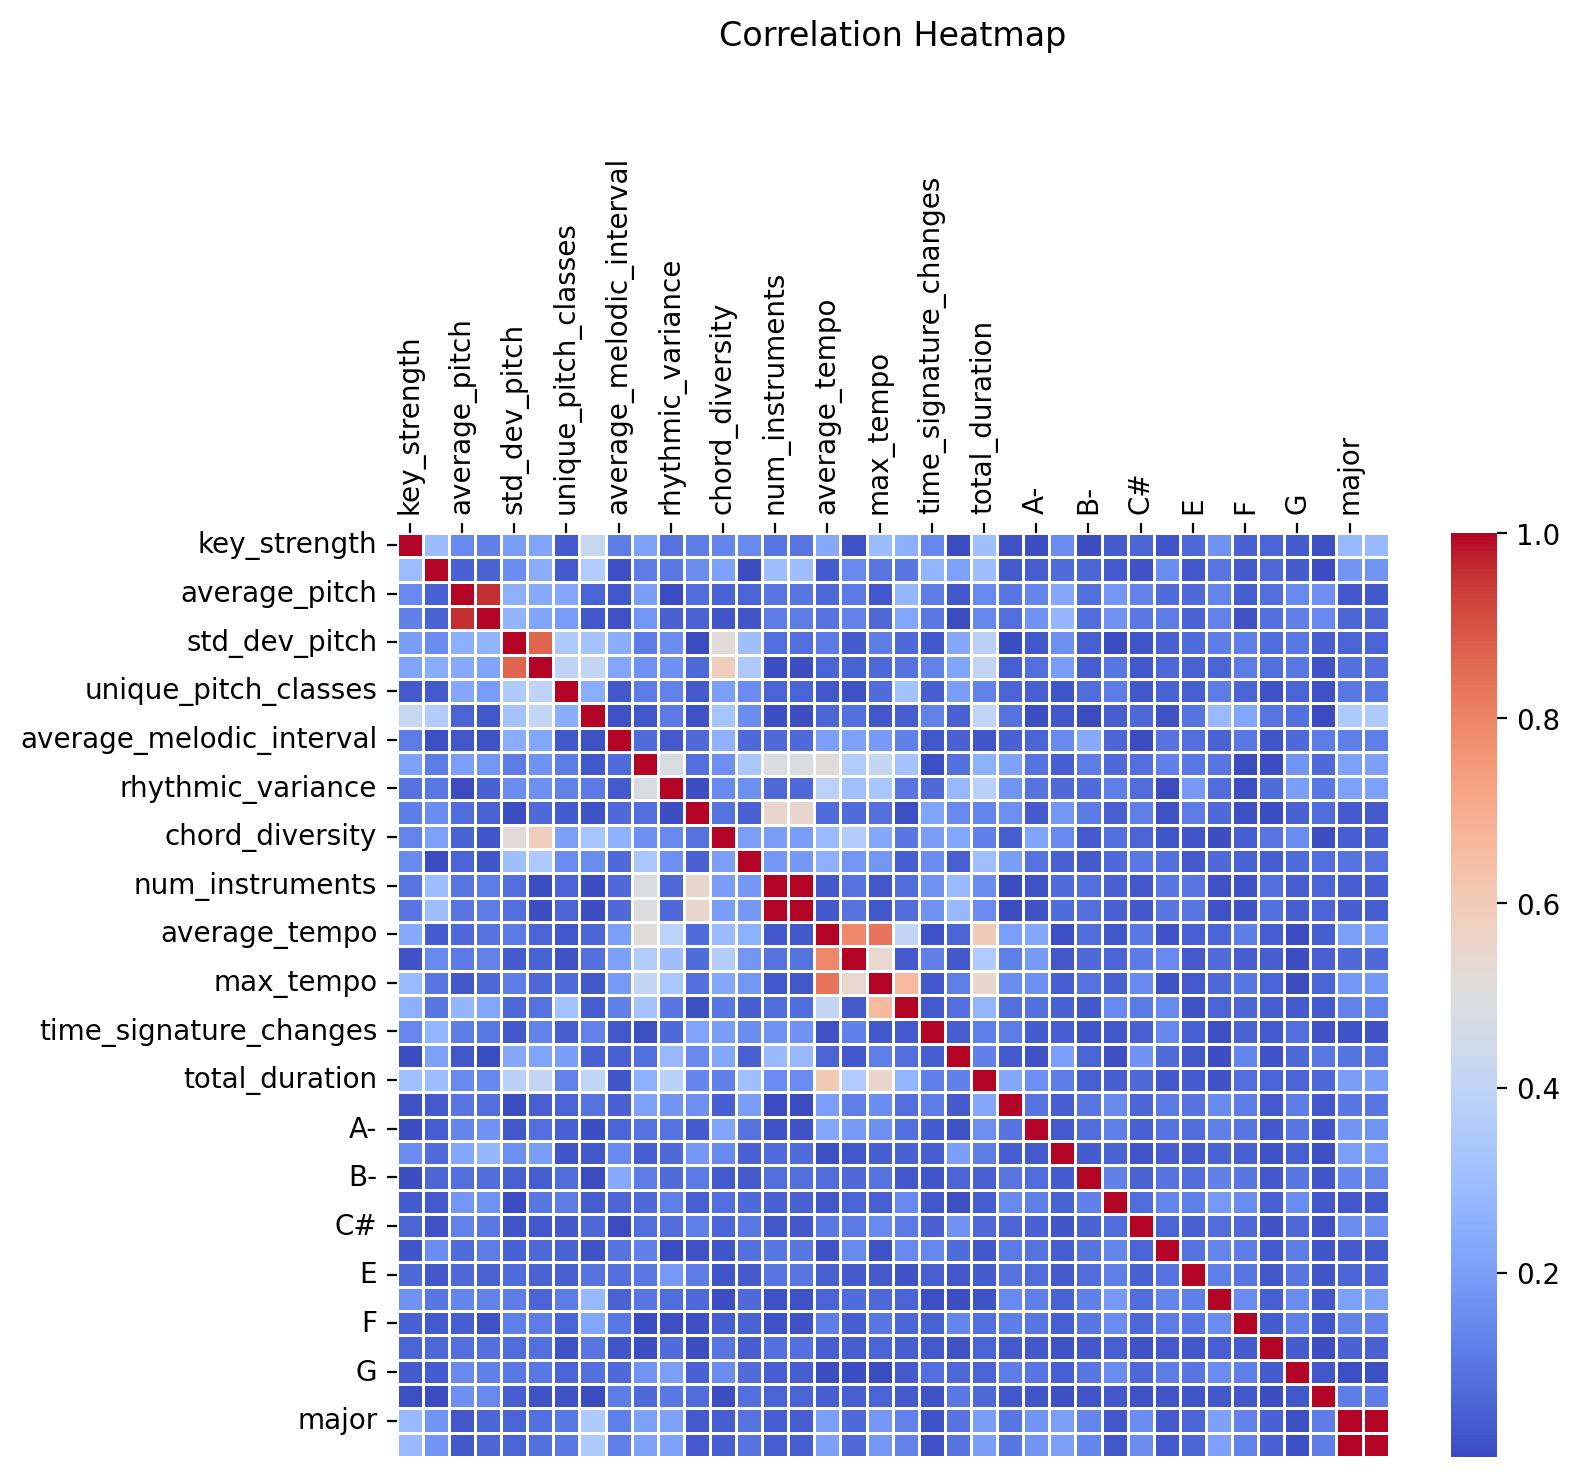

In [96]:
plot_correlation_heatmap(features_df, annot=False)

<span style="color:red">From the correlation matrix heatmap, we can draw the following conclusions:</span>
<ul style="color:red">
    <li>Correlation between features: There is little or no correlation between majority of the features and as such, most of them can be considered independent features. However, I will still try to screen those above 0.9, for completeness. </li>
</ul>

In [127]:
features_df = remove_correlated_features(features_df, 0.9)
features_df.head()
print(features_df.shape)

(186, 35)


<span style="color:red">**This removed 3 features**</span>

<h2 style="color:blue">3. Exploratory Data Analysis (EDA)</h2>

In this section, I will try to explore the data more, to understand some feature-target relationships. This section will include:
<ul>
    <li>Check for class balcance</li>
    <li>Perform PCA to identify and visualize clusters (to know if I would be able to find a good model)</li>
    <li>Remove low variance features (if any)</li>
</ul>

In [128]:
target_df.value_counts()

composer
1    127
3     25
0     17
2     17
Name: count, dtype: int64

In [129]:
# Satistical summary of the features
features_df.describe()

,key_strength,num_key_signature_changes,average_pitch,std_dev_pitch,pitch_range,unique_pitch_classes,pitch_entropy,average_melodic_interval,note_density,rhythmic_variance,...,C,C#,D,E,E-,F,F#,G,G#,major
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,...,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,0.884598,6.419355,62.982724,12.085782,59.833333,11.973118,3.247129,-0.002319,4.406024,0.233301,...,0.155914,0.032258,0.091398,0.069892,0.155914,0.107527,0.010753,0.107527,0.005376,0.715054
std,0.051661,7.161945,3.511224,2.205774,10.490107,0.162174,0.135767,0.006982,1.763322,0.183454,...,0.363753,0.177162,0.288952,0.255654,0.363753,0.310618,0.103415,0.310618,0.073324,0.452607
min,0.691156,0.000000,52.652174,5.272210,25.000000,11.000000,2.832748,-0.025000,1.275701,0.001716,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.854379,2.000000,61.429892,11.261471,58.000000,12.000000,3.166554,-0.005125,3.041501,0.090675,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.891410,4.000000,63.245311,12.439096,60.000000,12.000000,3.253541,-0.001412,4.143497,0.191507,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.923469,7.000000,64.979936,13.370445,65.750000,12.000000,3.332769,0.000703,5.294817,0.319826,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.967793,36.000000,72.565085,16.131535,77.000000,12.000000,3.553842,0.028152,9.502639,0.905232,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<span style="color:red">**Features are of different scales, therefore scaling would be needed during data preprocessing section**</span>

In [130]:
# Scaled statistics of the features to see the variability of the features
pd.DataFrame(MinMaxScaler().fit_transform(features_df), columns=features_df.columns).describe()

,key_strength,num_key_signature_changes,average_pitch,std_dev_pitch,pitch_range,unique_pitch_classes,pitch_entropy,average_melodic_interval,note_density,rhythmic_variance,...,C,C#,D,E,E-,F,F#,G,G#,major
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,...,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,0.699263,0.178315,0.518787,0.627440,0.669872,0.973118,0.574656,0.426714,0.380497,0.256316,...,0.155914,0.032258,0.091398,0.069892,0.155914,0.107527,0.010753,0.107527,0.005376,0.715054
std,0.186745,0.198943,0.176329,0.203123,0.201733,0.162174,0.188279,0.131354,0.214335,0.203044,...,0.363753,0.177162,0.288952,0.255654,0.363753,0.310618,0.103415,0.310618,0.073324,0.452607
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.590026,0.055556,0.440805,0.551532,0.634615,1.000000,0.462916,0.373932,0.214636,0.098459,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.723887,0.111111,0.531973,0.659975,0.673077,1.000000,0.583548,0.443784,0.348586,0.210058,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.839774,0.194444,0.619084,0.745740,0.783654,1.000000,0.693420,0.483563,0.488531,0.352080,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<span style="color:red">**The standard deviation varies slightly across features, I might consider removing low variance features (if any)**</span>

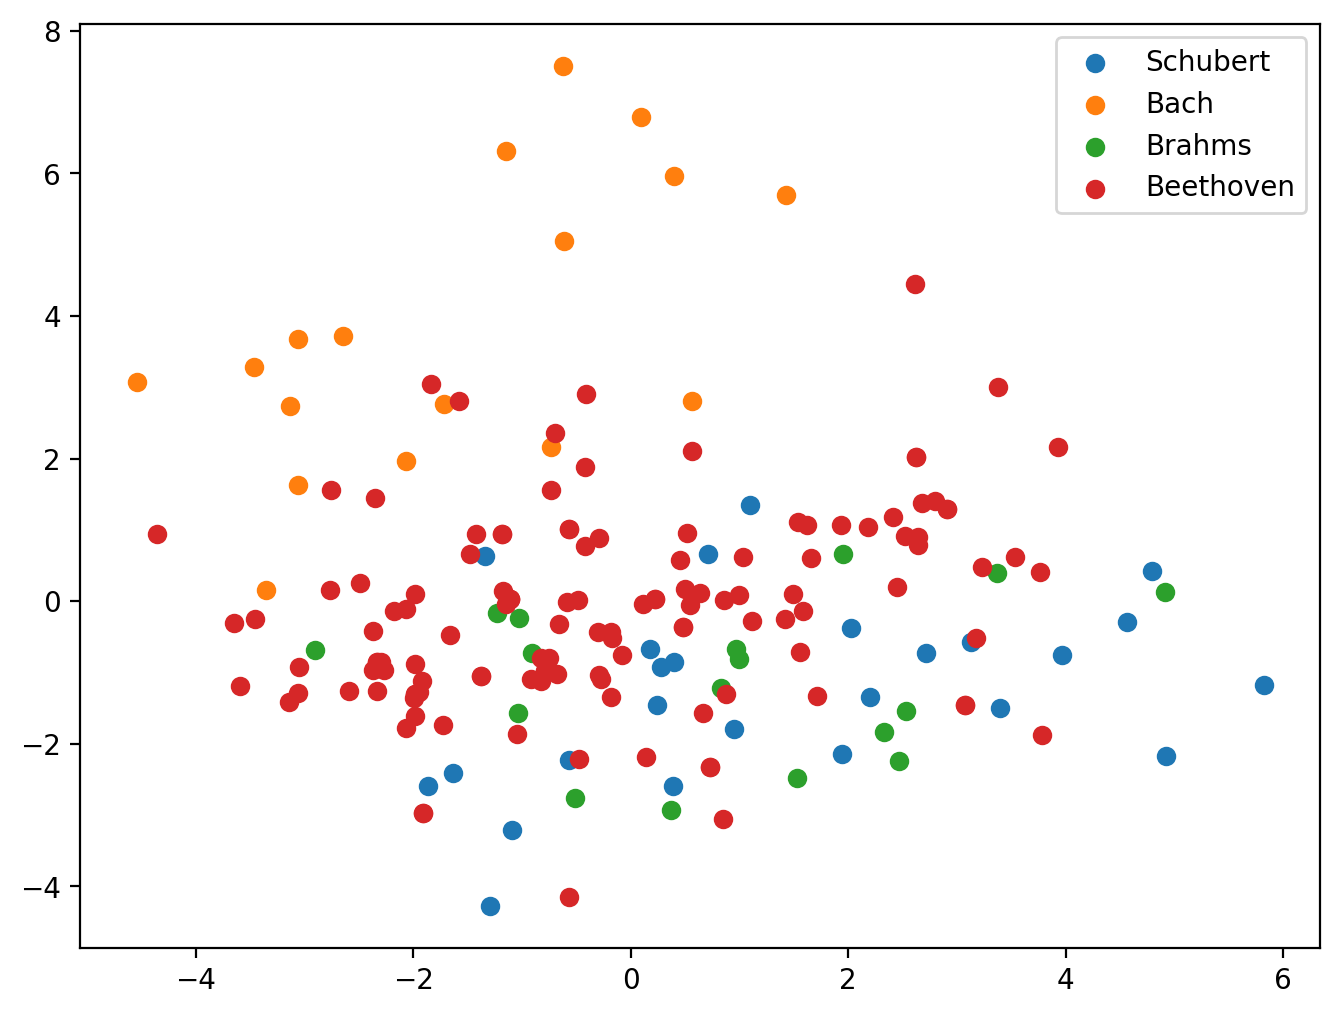

In [100]:
plot_pca(features_df, target_df_copy)

<span style="color:red">**The PCA does not reveal clear clusters, this might be difficult for the model to classify these composers. Limited dataset is also a contraint here.**</span><br>
<span style="color:red">**Checking for low variance features, which would probably have less impact on the target**.</span>

In [131]:
features_df = remove_low_variance_features(features_df, 0.01)
print(features_df.shape)
features_df.head()

(186, 34)


,key_strength,num_key_signature_changes,average_pitch,std_dev_pitch,pitch_range,unique_pitch_classes,pitch_entropy,average_melodic_interval,note_density,rhythmic_variance,...,B-,C,C#,D,E,E-,F,F#,G,major
0,0.883717,4,52.871897,6.164130,31.0,12,3.134150,-0.016899,3.814394,0.044021,...,0,1,0,0,0,0,0,0,0,1
1,0.886779,4,52.956790,6.183093,31.0,11,3.075162,0.005149,3.908163,0.020716,...,0,1,0,0,0,0,0,0,0,1
2,0.877006,4,52.731313,6.011649,28.0,12,3.185360,-0.024267,1.952663,0.048907,...,0,0,0,0,0,0,0,0,0,0
3,0.876151,4,53.013825,6.446861,31.0,12,3.267104,0.000000,2.972222,0.181419,...,0,1,0,0,0,0,0,0,0,1
4,0.838132,9,54.097643,5.423326,29.0,11,3.231178,-0.017978,1.674812,0.117052,...,0,1,0,0,0,0,0,0,0,1


<span style="color:red">**This removed 1 feature**</span>

In [103]:
print(features_df.shape)
features_df.head()

(186, 34)


,key_strength,num_key_signature_changes,average_pitch,std_dev_pitch,pitch_range,unique_pitch_classes,pitch_entropy,average_melodic_interval,note_density,rhythmic_variance,...,B-,C,C#,D,E,E-,F,F#,G,major
0,0.883717,4,52.871897,6.164130,31.0,12,3.134150,-0.016899,3.814394,0.044021,...,0,1,0,0,0,0,0,0,0,1
1,0.886779,4,52.956790,6.183093,31.0,11,3.075162,0.005149,3.908163,0.020716,...,0,1,0,0,0,0,0,0,0,1
2,0.877006,4,52.731313,6.011649,28.0,12,3.185360,-0.024267,1.952663,0.048907,...,0,0,0,0,0,0,0,0,0,0
3,0.876151,4,53.013825,6.446861,31.0,12,3.267104,0.000000,2.972222,0.181419,...,0,1,0,0,0,0,0,0,0,1
4,0.838132,9,54.097643,5.423326,29.0,11,3.231178,-0.017978,1.674812,0.117052,...,0,1,0,0,0,0,0,0,0,1


In [104]:
features_list = features_df.columns.tolist()

# save the features list to a csv file for inference
pd.DataFrame(features_list, columns=['features']).to_csv('../model/features_list.csv', index=False)

<span style="color:red"> From the EDA analysis, we can draw the following conclusions: </span>
<ul style="color:red">
    <li>Overlapping clusters: The PCA plot shows no distinct (clear) boundaries and this indicates that the features may not
    provide enough information to seperate classes or predict the outcomes effectively</li>
    <li>Low Variance : A few feature had variance below the pre-set variance threshold (of 0.01) and this feature was removed (as considered low impact feature)</li>
</ul>

<h2 style="color:blue"> 4. Data Preprocessing</h2>

In this section, I will preprocess the data for training. This section will include:
<ul>
    <li>Scaliing</li>
    <li>Transformation (if required)</li>
    <li>Test-Train Split</li>
</ul>

In [124]:
# Scale the features using MaxMinScaler
scaler = MinMaxScaler()
scaled_features_df = scaler.fit_transform(features_df)

# save the scaler object to a file for inference
joblib.dump(scaler, '../model/feature_scaler.pkl')

['../model/feature_scaler.pkl']

In [125]:
X = scaled_features_df
y = target_df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2 style="color:blue"> 5. Model Selection, Feature Engineering and Hyperparameter Optimization</h2>

In this section, I seek to select the best model, features (and/or feature combinations) and hyperparameters. This section will include:
<ul>
    <li>K-fold Cross Validation</li>
    <li>Feature Engineering (Selecting the best combination of features using selectKBest)</li>
    <li>Hyperparameter Optimization (Bayesian Optimization using hyperopt) </li>
</ul>

In [126]:
n_features = X_train.shape[1]
n_features

34

<span style="color:red">**The total number of features is 34, however, during model selection optimization, the number of features (and/or feature combinations) <b>K</b> will be optimized, with selectKBest.**</span>

In [127]:
# define the search space
search_space = create_search_space(n_features)
search_space

{'model': <hyperopt.pyll.base.Apply at 0x2603197a460>,
 'polynomialfeatures_degree': <hyperopt.pyll.base.Apply at 0x2603197a9a0>,
 'selectkbest_k': <hyperopt.pyll.base.Apply at 0x2603197aaf0>}

In [128]:

# Objective function to minimize
def objective(params):
    model_name = params['model']['type']
    del params['model']['type']
    
    if model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(**params['model'])
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(**params['model'])
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(**params['model'])
    elif model_name == 'LGBMClassifier':
        model = LGBMClassifier(**params['model'],verbosity=-1)
    elif model_name == 'CatBoostClassifier':
        model = CatBoostClassifier(**params['model'], verbose=False)
    elif model_name == 'GaussianNB':
        model = GaussianNB()
    elif model_name == 'KNeighborsClassifier':
        model = KNeighborsClassifier(**params['model'])
    elif model_name == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(**params['model'])
    elif model_name == 'AdaBoostClassifier':
        model = AdaBoostClassifier(**params['model'])
    elif model_name == 'GradientBoostingClassifier':
        model = GradientBoostingClassifier(**params['model'])
    elif model_name == 'ExtraTreesClassifier':
        model = ExtraTreesClassifier(**params['model'])

    model_pipeline = make_pipeline(
        PolynomialFeatures(degree=params['polynomialfeatures_degree']),
        SelectKBest(f_regression, k=params['selectkbest_k']),
        model
    )
    
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_log_loss')
    log_loss_cv = -scores.mean() 
    
    return {
        'loss': log_loss_cv,
        'status': STATUS_OK,
        'model_pipeline': model_pipeline,
    }

trials = Trials()
best = fmin(objective, search_space, algo=tpe.suggest, max_evals=5000, trials=trials)

100%|██████████| 5000/5000 [2:25:09<00:00,  1.74s/trial, best loss: 0.37969258195126837]   


<span style="color:red">**In this robust optimization scheme (bayesian optimization), I seek to find the optimal model, hyper-parameters and feature combinations that minimizes the log loss (for this classification task).**</span>

In [129]:
best_params = space_eval(search_space, best)
best_params

{'model': {'max_depth': 19,
  'max_features': None,
  'n_estimators': 60,
  'type': 'ExtraTreesClassifier'},
 'polynomialfeatures_degree': 2,
 'selectkbest_k': 33}

<span style="color:red">**After 5000 trials, the best classifier was ExtraTreesClassifier and the optimized number of fetures was 33, this includes the transformed features from polynomial interaction.**</span>

<h2 style="color:blue"> 6. Model Re-training, Inference, Evaluation and Saving</h2>

In this section, I will re-train with the best model and hyper-paramaters from the previous secction. This section will include:
<ul>
    <li>Model Re-training</li>
    <li>Feature Importance</li>
    <li>Model Saving</li>
</ul>

In [130]:
best_model_name = best_params['model']['type']
best_model_name

'ExtraTreesClassifier'

In [131]:
best_params['model']

{'max_depth': 19,
 'max_features': None,
 'n_estimators': 60,
 'type': 'ExtraTreesClassifier'}

In [132]:
# Rebuild the pipeline with the best parameters
best_model_name = best_params['model']['type']
del best_params['model']['type']

if best_model_name == 'RandomForestClassifier':
    best_model = RandomForestClassifier(**best_params['model'])
elif best_model_name == 'LogisticRegression':
    best_model = LogisticRegression(**best_params['model'])
elif best_model_name == 'XGBClassifier':
    best_model = XGBClassifier(**best_params['model'])
elif best_model_name == 'LGBMClassifier':
    best_model = LGBMClassifier(**best_params['model'],verbosity=-1, force_row_wise=True)
elif best_model_name == 'CatBoostClassifier':
    best_model = CatBoostClassifier(**best_params['model'], verbose=False)
elif best_model_name == 'GaussianNB':
    best_model = GaussianNB()
elif best_model_name == 'KNeighborsClassifier':
    best_model = KNeighborsClassifier(**best_params['model'])
elif best_model_name == 'DecisionTreeClassifier':
    best_model = DecisionTreeClassifier(**best_params['model'])
elif best_model_name == 'AdaBoostClassifier':
    best_model = AdaBoostClassifier(**best_params['model'])
elif best_model_name == 'GradientBoostingClassifier':
    best_model = GradientBoostingClassifier(**best_params['model'])
elif best_model_name == 'ExtraTreesClassifier':
    best_model = ExtraTreesClassifier(**best_params['model'])


# Create the pipeline with the best parameters
best_model_pipeline = make_pipeline(
    PolynomialFeatures(degree=best_params['polynomialfeatures_degree']),  # Use the best degree
    SelectKBest(f_regression, k=best_params['selectkbest_k']),  # Use the best k features
    best_model
)

In [133]:
# Fit the pipeline on the full training data
best_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('selectkbest',
                 SelectKBest(k=33,
                             score_func=<function f_regression at 0x000002601C5AED30>)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(max_depth=19, max_features=None,
                                      n_estimators=60))])

In [134]:
# evaluate the model on the test data
best_model_pipeline.score(X_test, y_test)

0.868421052631579

<span style="color:red">**The average score looks good, but we will discuss more under perfromance metrics section.**</span>

In [135]:
# Sving the model pipline
joblib.dump(best_model_pipeline, '../model/best_model_pipeline_0.868_score.joblib')

['../model/best_model_pipeline_0.868_score.joblib']

<span style="color:red">**It would interesting to know what specific features are contributing greating to the model's prediction. For this, we perform a feature importance analysis.**</span>

In [136]:
selected_features_indices = best_model_pipeline.named_steps['selectkbest'].get_support(indices=True)
poly = best_model_pipeline.named_steps['polynomialfeatures']
transformed_feature_names = poly.get_feature_names_out(input_features=features_df.columns)
# map the selected indices to the transformed feature names
selected_features = transformed_feature_names[selected_features_indices]
selected_features

array(['std_dev_pitch', 'pitch_range', 'time_signature_changes',
       'average_pitch pitch_range', 'average_pitch rest_proportion',
       'average_pitch time_signature_changes',
       'std_dev_pitch pitch_range', 'std_dev_pitch unique_pitch_classes',
       'std_dev_pitch pitch_entropy', 'std_dev_pitch rest_proportion',
       'std_dev_pitch num_instruments',
       'std_dev_pitch time_signature_changes', 'pitch_range^2',
       'pitch_range unique_pitch_classes', 'pitch_range pitch_entropy',
       'pitch_range rest_proportion', 'pitch_range num_instruments',
       'pitch_range time_signature_changes', 'pitch_range total_duration',
       'unique_pitch_classes time_signature_changes',
       'pitch_entropy rest_proportion', 'pitch_entropy chord_diversity',
       'pitch_entropy time_signature_changes',
       'rhythmic_variance rest_proportion',
       'rest_proportion chord_diversity',
       'rest_proportion consonance_ratio',
       'rest_proportion time_signature_changes',
  

In [137]:
# Get the feature importances
if best_model_name == 'RandomForestClassifier':
    feature_importances = best_model_pipeline.named_steps['randomforestclassifier'].feature_importances_
elif best_model_name == 'XGBClassifier':
    feature_importances = best_model_pipeline.named_steps['xgbclassifier'].feature_importances_
elif best_model_name == 'LGBMClassifier':
    feature_importances = best_model_pipeline.named_steps['lgbmclassifier'].feature_importances_
elif best_model_name == 'CatBoostClassifier':
    feature_importances = best_model_pipeline.named_steps['catboostclassifier'].feature_importances_
elif best_model_name == 'DecisionTreeClassifier':
    feature_importances = best_model_pipeline.named_steps['decisiontreeclassifier'].feature_importances_
elif best_model_name == 'AdaBoostClassifier':
    feature_importances = best_model_pipeline.named_steps['adaboostclassifier'].feature_importances_
elif best_model_name == 'GradientBoostingClassifier':
    feature_importances = best_model_pipeline.named_steps['gradientboostingclassifier'].feature_importances_
elif best_model_name == 'ExtraTreesClassifier':
    feature_importances = best_model_pipeline.named_steps['extratreesclassifier'].feature_importances_

feature_importances
# map the feature importances to the selected features
selected_features_importances = pd.Series(feature_importances, index=selected_features)
# Sort the features by importance
selected_features_importances = selected_features_importances.sort_values(ascending=False)
selected_features_importances

pitch_range^2                                  0.100832
pitch_range                                    0.078340
pitch_range num_instruments                    0.059309
consonance_ratio time_signature_changes        0.053993
std_dev_pitch                                  0.051149
pitch_range unique_pitch_classes               0.048127
pitch_entropy rest_proportion                  0.047431
std_dev_pitch num_instruments                  0.044986
std_dev_pitch pitch_range                      0.043597
num_instruments total_duration                 0.038317
chord_diversity num_instruments                0.032383
average_pitch pitch_range                      0.032120
rest_proportion time_signature_changes         0.027232
num_instruments time_signature_changes         0.026603
pitch_range pitch_entropy                      0.026026
pitch_range rest_proportion                    0.025019
std_dev_pitch unique_pitch_classes             0.022937
rest_proportion consonance_ratio               0

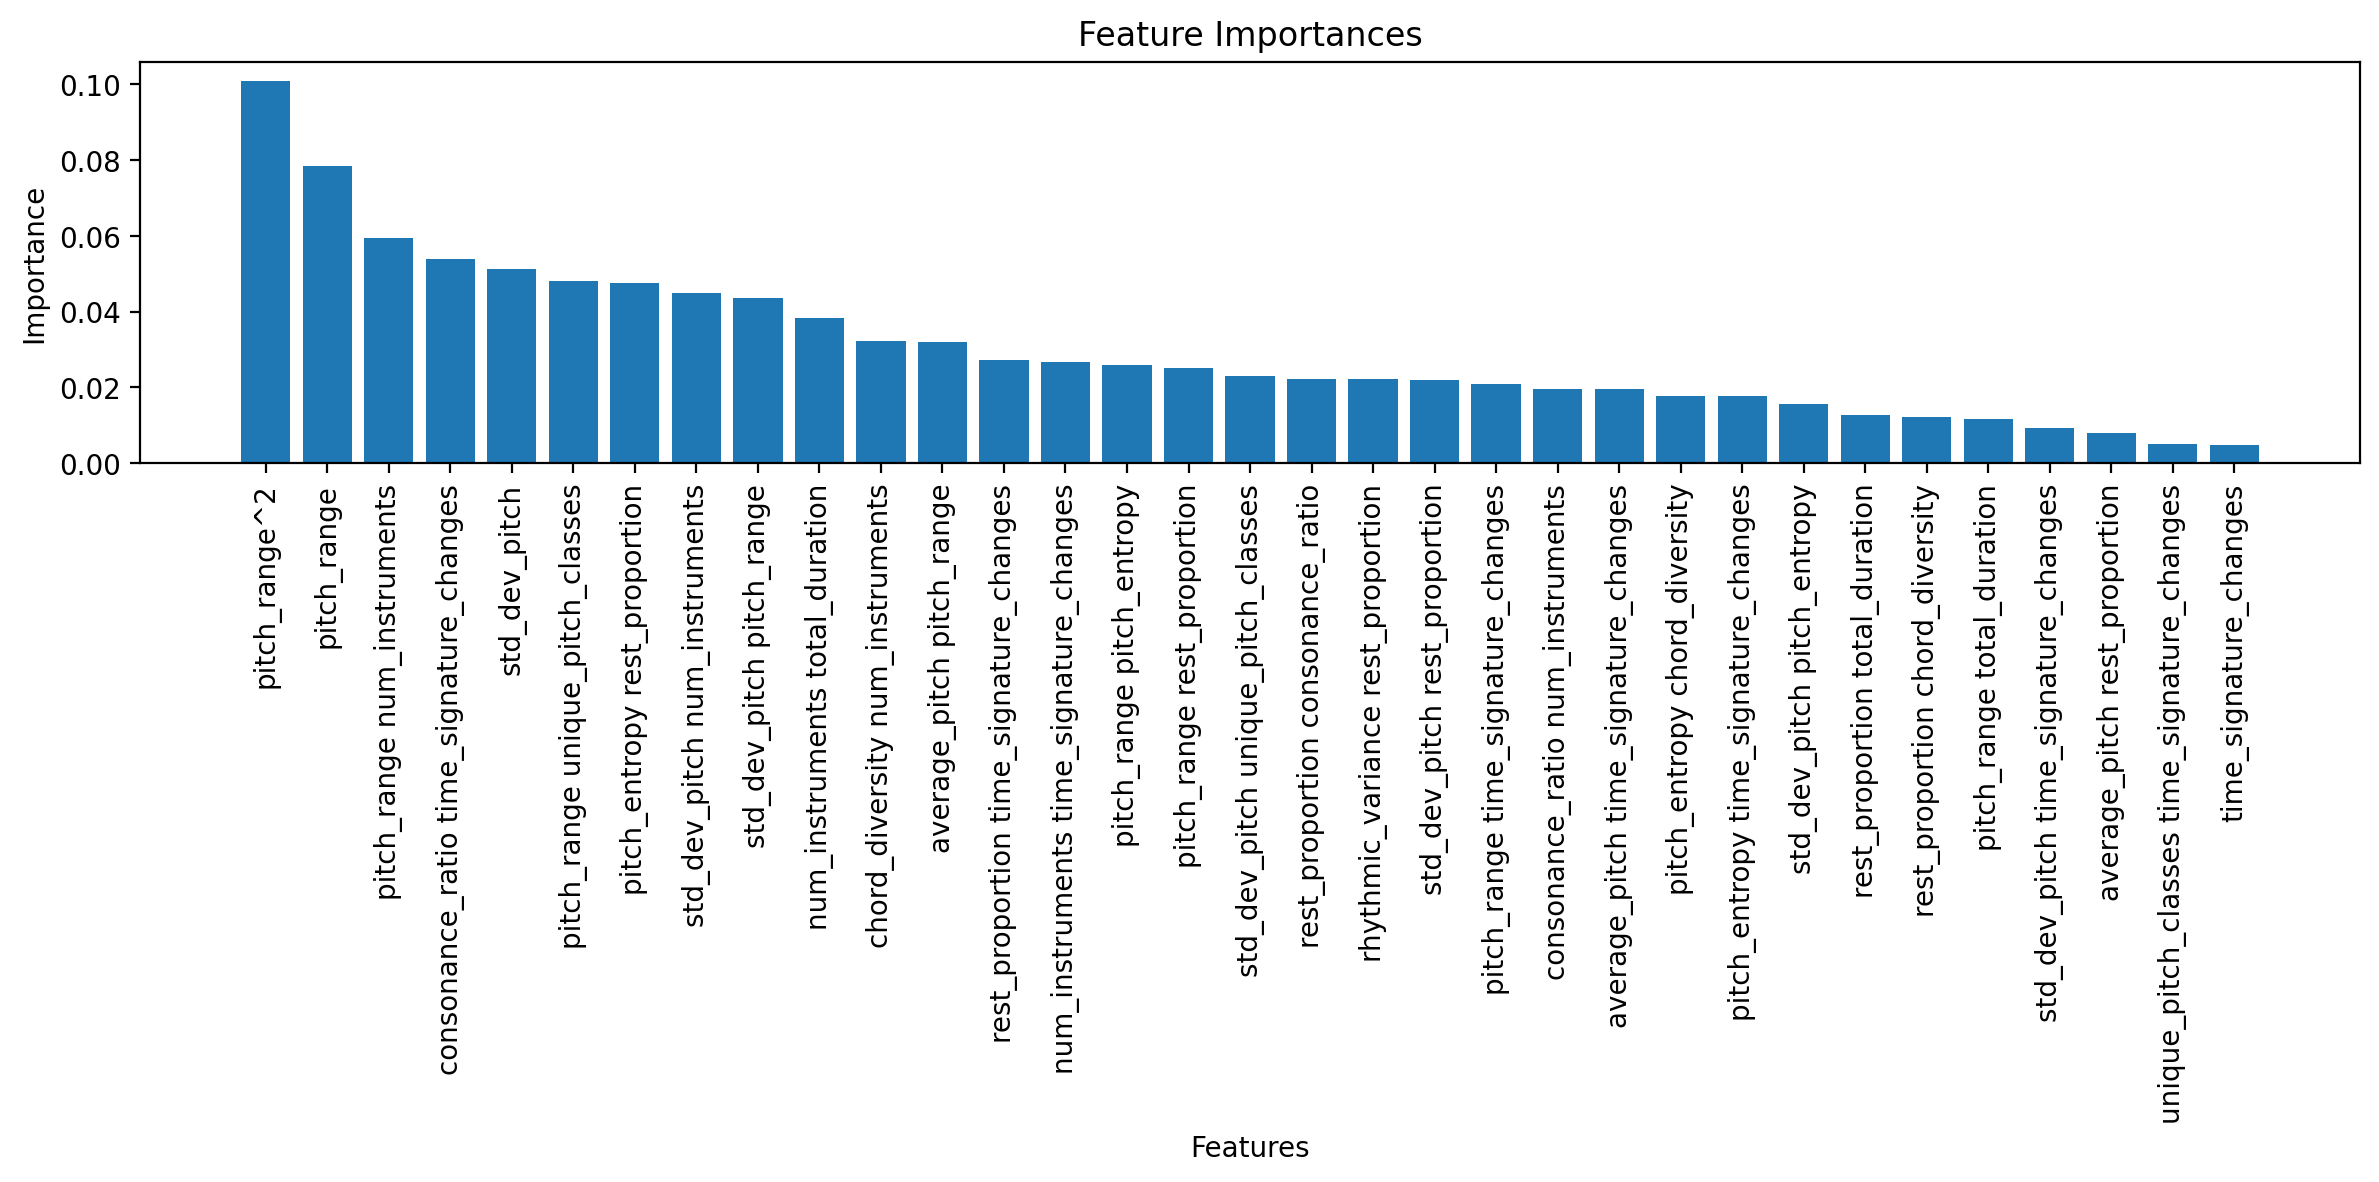

In [138]:
plot_feature_importances(feature_importances, selected_features)

<span style="color:red">**From the features-importance plot, the <b>pitch features</b> seems to be a strong determinant of the composer.**</span>

<span style="color:green"><b>The feature importance analysis highlights that pitch-related features, such as <span style="color:red">pitch_range^2</span>, <span style="color:red">pitch_range</span>, and their interactions with other attributes like <span style="color:red">num_instruments</span> and <span style="color:red">consonance_ratio</span>, are the most significant contributors to predicting the composer. This aligns with musical theory, as composers often have distinct preferences for pitch range and variation, which reflect their unique styles. Additionally, features like time_signature_changes and consonance_ratio capture rhythmic and harmonic characteristics that further differentiate composers. These findings suggest that the model effectively leverages melodic and structural elements to achieve accurate predictions.<b><span>

<h2 style="color:blue"> 7. Model Performance Metrics</h2>

In this section, I seek to access and discuss the performance of the model. This section will include:
<ol>
    <li>Confussion Matrix</li>
    <li>Classification Report</li>
</ol>

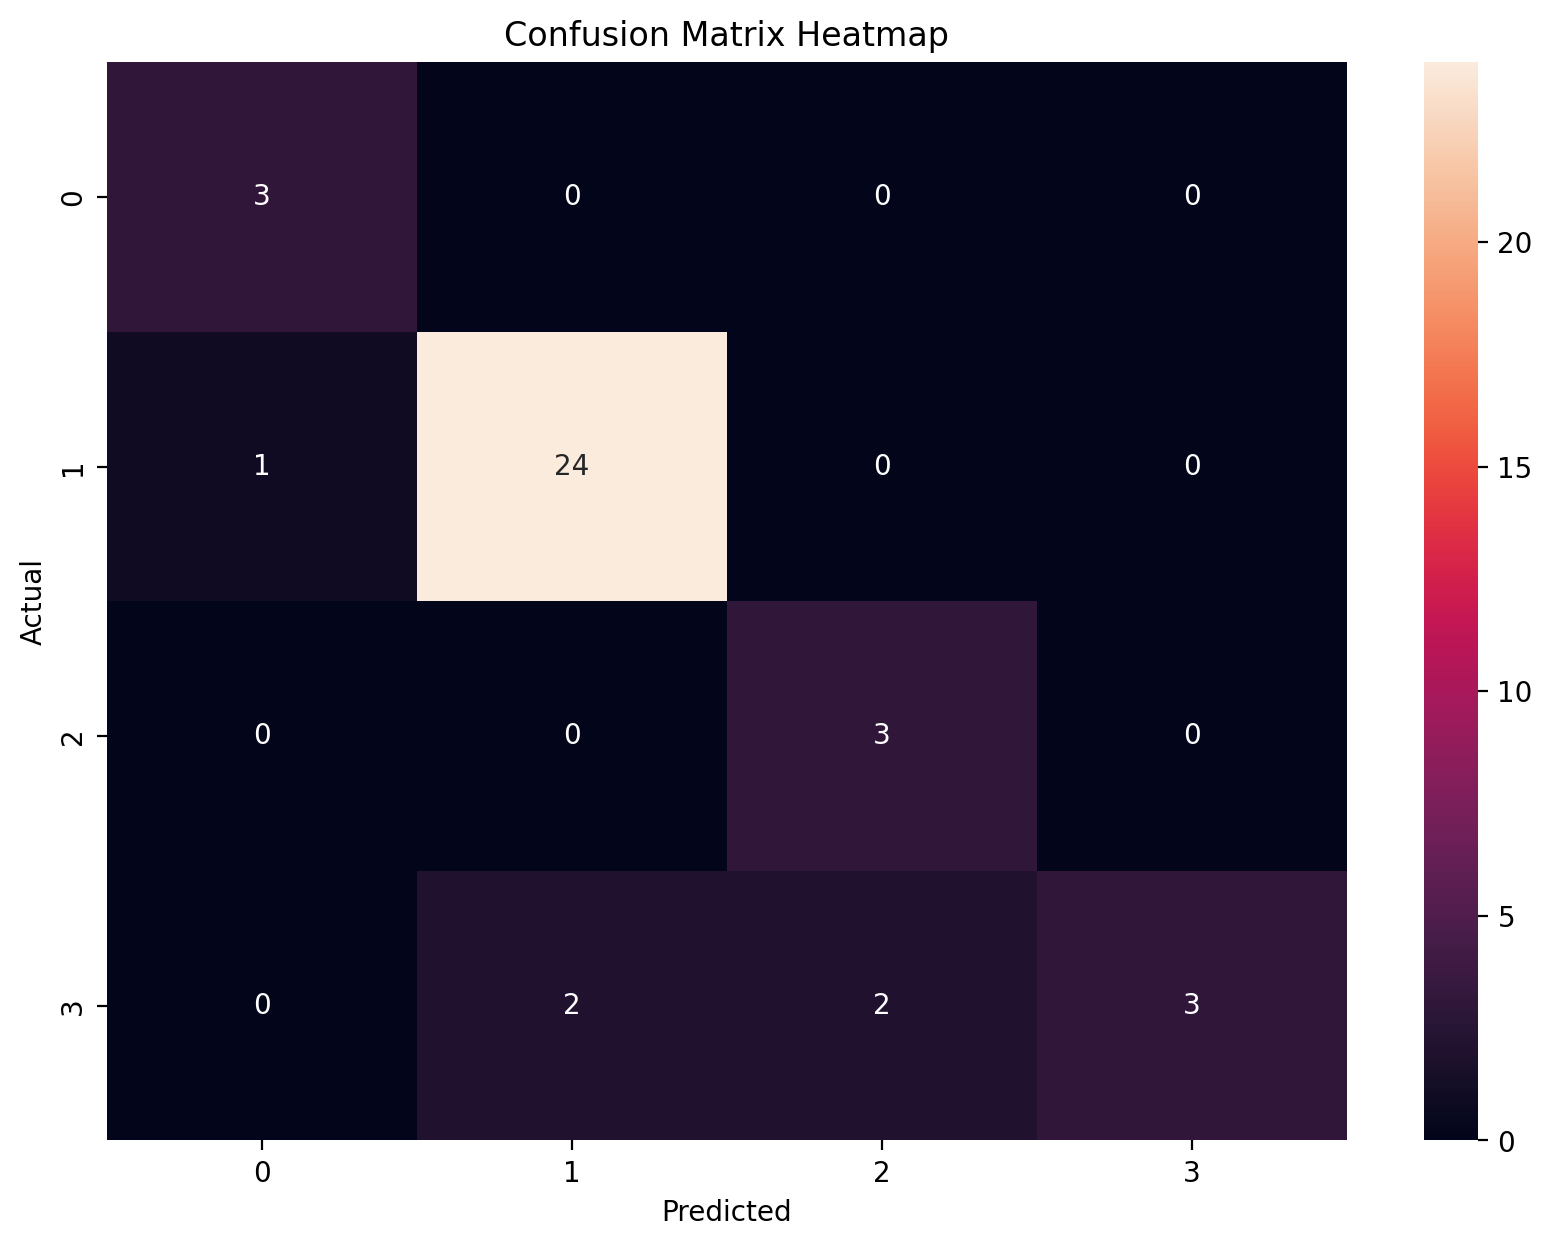

In [139]:
y_pred = best_model_pipeline.predict(X_test)
confusion_matrix_heatmap(y_test, y_pred)

<span style="color:red">**Most of the off-diagonal elements are zeros, which shows that the predicted differs from the actual on <br> very few occasions, indicating that the model performed well.** </span>

<span style="color:red"> The model achieved an average accuracy of approximately <b>86.8%</b>, which is a promising result given the class imbalance and the limited size of the dataset. The confusion matrix indicates that the model performs particularly well on the majority class (Beethoven, labeled as 1), with 24 out of 25 samples correctly classified. However, performance on Schubert (3), is less consistent, with noticeable misclassifications; having the least recall of <b>43%</b>(that is, correctly identifying 3 out of a total of 7 Schubert in the test set).<span>

In [140]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.92      0.96      0.94        25
           2       0.60      1.00      0.75         3
           3       1.00      0.43      0.60         7

    accuracy                           0.87        38
   macro avg       0.82      0.85      0.79        38
weighted avg       0.90      0.87      0.86        38



<span style="color:red">The precision, recall, and F1-score provide additional insights into the model's performance:
    Precision measures how many of the predicted labels were actually correct. It represents the proportion of correct predictions among all predictions made for a class For instance, Beethoven (class 1) has a precision of 92%, meaning that when the model predicts Beethoven, it's correct 92% of the time.
    Recall indicates how well the model identifies all instances of a class. For Bach (class 0), recall is 100%, meaning the model correctly identified all Bach samples in the test set.
    F1-score balances precision and recall, and for Brahms (class 2) and Schubert (class 3), the scores are lower, reflecting the difficulty in consistently handling minority classes.
</span>

**An analysis of the data distribution reveals class imbalance, with Beethoven (class 1) having 127 samples compared to only 17–25 samples for other composers. This imbalance likely influences the model's bias toward the majority class, as evidenced by the higher precision and recall for Beethoven. The lower scores for minority classes highlight the impact of limited training data, as well as possible overlaps in the feature space for the less-represented composers.**

**The model's ability to handle the minority classes could be improved by addressing the imbalance in the training data. Potential solutions include techniques such as oversampling the minority classes, data augmentation, or collecting additional data for the underrepresented composers. Additionally, incorporating more advanced algorithms or domain-specific feature engineering could further improve performance.**

<span style="color:green"><b>The model demonstrates strong performance on the majority class and reasonable performance overall, given the constraints of class imbalance and limited data. However, it shows room for improvement, particularly for the minority classes. Future work could focus on addressing these limitations to create a more balanced and robust classifier.</b></span>

<h2 style="color:blue"> 8. Model Inference on Unlabeled Data</h2>

In this section, I seek to make inference on the unlabeled data. This section will include:
<ol>
    <li>Preparation of the unlabeled data for prediction</li>
    <li>Prediction on the unlabeled</li>
</ol>

In [163]:
processed_data_unknown = extract_features_from_mdi('../data/raw/Part1(PS2)/', 'unknown')
# save processed data to csv
processed_data_unknown.to_csv('../data/processed/processed_data_unknown.csv', index=False)

Error processing ../data/raw/Part1(PS2)\0.539512676743813_adj.mid: 2612037775120
Error analyzing key for ../data/raw/Part1(PS2)\0.7491289879531658_adj.mid: 'Unpitched' object has no attribute 'pitch'


In [133]:
# Subsequently load the processed data from the csv file
processed_data_unknown = pd.read_csv('../data/processed/processed_data_unknown.csv')
processed_data_unknown

,key_name,key_mode,key_strength,num_key_signature_changes,most_frequent_key_signature,average_pitch,median_pitch,std_dev_pitch,pitch_range,unique_pitch_classes,...,most_common_instrument,average_tempo,min_tempo,max_tempo,tempo_variability,time_signature_changes,most_frequent_time_signature,measure_count,total_duration,composer
0,C,major,0.931962,4,0.0,65.218633,66.0,10.545467,55.0,12,...,SFL,102.750000,40.0,130.0,28.340563,8,3/4,0,963.0,unknown
1,B,minor,0.908940,3,2.0,68.676913,71.0,11.108826,51.0,12,...,SFL,100.000000,88.0,108.0,6.825558,3,3/4,0,375.0,unknown
2,E-,major,0.887868,4,-3.0,66.488552,67.0,11.192664,68.0,12,...,SFL,130.403846,104.0,144.0,10.986460,8,1/4,0,1112.0,unknown
3,C,minor,0.861038,2,-3.0,58.044706,58.0,11.411310,53.0,12,...,SFL,275.333333,200.0,300.0,24.729649,2,3/4,0,648.0,unknown
4,C,minor,0.920158,0,NaN,58.891206,59.0,7.498501,44.0,12,...,NaN,69.554688,22.0,110.0,25.224617,2,4/4,0,156.0,unknown
5,A,minor,0.934357,1,0.0,76.657807,76.0,5.783972,30.0,11,...,SFL,70.000000,70.0,70.0,0.000000,1,3/4,0,138.0,unknown
6,C,minor,0.859349,3,-3.0,53.251613,53.0,5.644973,31.0,12,...,SFL,190.000000,130.0,250.0,60.000000,3,3/4,0,387.0,unknown
7,G,major,0.873430,6,1.0,66.677091,66.0,9.638568,45.0,12,...,SFL,107.892857,60.0,120.0,13.283554,4,1/4,0,364.0,unknown
8,C,major,0.815727,4,1.0,63.665437,64.0,12.945813,60.0,12,...,SFL,262.895833,200.0,360.0,24.832556,4,2/2,0,1652.0,unknown
9,A,minor,0.958729,1,0.0,74.868687,75.0,5.322974,29.0,12,...,SFL,133.333333,50.0,250.0,84.983659,1,3/4,0,255.0,unknown


<span style="color:red">The loaded .mid files with unknown composers would need to be preprocessed before we can make prediction on them with our saved model. <br> The preprocessing steps is the same as how we prepared and processed the training data. We would have to:
    <ul style="color:red">
        <li>
             Drop "most_frequent_key_signatures", "most_commom_chord", "most_common_instrument and "measure_count" columns.
        </li>
        <li>
            Remove rows with NAN in keyname columns (rows corresponding to no sound).
        </li>
        <li>
            One-hot encode "key_name" and "key_mode" columns.
        </li>
        <li>
            Convert "note_density", "total_duration" and "most_frequent_time_signature" columns to float.
        </li>
        <li>
            Drop the composer column.
        </li>
        <li>
            Transform the columns with the same scaler used in scaling the training dataset.
        </li>
        <li>
            Filter the features to retain only the features that are recognized by the saved model pipeline.
        </li>
    </ul>
</span>

In [134]:
# load the features list for which the model was trained
features_list = pd.read_csv('../model/features_list.csv')
features_list = features_list['features'].tolist()
features_list

['key_strength',
 'num_key_signature_changes',
 'average_pitch',
 'std_dev_pitch',
 'pitch_range',
 'unique_pitch_classes',
 'pitch_entropy',
 'average_melodic_interval',
 'note_density',
 'rhythmic_variance',
 'rest_proportion',
 'chord_diversity',
 'consonance_ratio',
 'num_instruments',
 'average_tempo',
 'min_tempo',
 'max_tempo',
 'tempo_variability',
 'time_signature_changes',
 'most_frequent_time_signature',
 'total_duration',
 'A',
 'A-',
 'B',
 'B-',
 'C',
 'C#',
 'D',
 'E',
 'E-',
 'F',
 'F#',
 'G',
 'major']

In [135]:
# import the scaler object to scale the features
scaler = joblib.load('../model/feature_scaler.pkl')
scaler

MinMaxScaler()

In [136]:
# preprocess the inference data
inference_data = preprocess_inference_data(processed_data_unknown, features_list, scaler)
inference_data

array([[0.87047721, 0.11111111, 0.63107092, ..., 0.        , 0.        ,
        1.        ],
       [0.78725693, 0.08333333, 0.80474116, ..., 0.        , 0.        ,
        0.        ],
       [0.71108245, 0.11111111, 0.69484457, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.9557037 , 0.16666667, 0.50924104, ..., 0.        , 0.        ,
        1.        ],
       [0.79241646, 0.11111111, 0.58930822, ..., 0.        , 0.        ,
        0.        ],
       [0.83622731, 0.22222222, 0.63686278, ..., 0.        , 0.        ,
        1.        ]])

In [137]:
# Load the best model pipeline
model_pipeline = joblib.load('../model/best_model_pipeline_0.868_score.joblib')
classify = model_pipeline.predict(inference_data)
classify

array([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 0, 0,
       1, 0, 0, 1, 3, 0, 1, 0, 1, 1, 1], dtype=int64)

In [138]:
# Get the probabilities of each class for each sample in the inference data set
model_pipeline.predict_proba(inference_data)

array([[0.1       , 0.73333333, 0.1       , 0.06666667],
       [0.75      , 0.2       , 0.        , 0.05      ],
       [0.03333333, 0.71666667, 0.        , 0.25      ],
       [0.11666667, 0.8       , 0.        , 0.08333333],
       [0.93333333, 0.06666667, 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.71666667, 0.28333333, 0.        , 0.        ],
       [0.03333333, 0.83333333, 0.01666667, 0.11666667],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.61666667, 0.05      , 0.33333333],
       [0.01666667, 0.11666667, 0.5       , 0.36666667],
       [0.01666667, 0.36666667, 0.51666667, 0.1       ],
       [0.01666667, 0.31666667, 0.35      , 0.31666667],
       [0.03333333, 0.65      , 0.        , 0.31666667],
       [0.01666667, 0.75      , 0.06666667, 0.16666667],
       [0.03333333, 0.9       , 0.        , 0.06666667],
       [0.03333333, 0.9       ,

In [139]:
# Get the maximum probability of each class for each sample in the inference data set
max_probs = model_pipeline.predict_proba(inference_data).max(axis=1)
max_probs

array([0.73333333, 0.75      , 0.71666667, 0.8       , 0.93333333,
       1.        , 1.        , 0.71666667, 0.83333333, 1.        ,
       0.61666667, 0.5       , 0.51666667, 0.35      , 0.65      ,
       0.75      , 0.9       , 0.9       , 0.71666667, 0.5       ,
       1.        , 0.85      , 0.9       , 0.51666667, 0.45      ,
       0.9       , 0.51666667, 1.        , 0.88333333, 0.9       ,
       0.86666667, 0.86666667, 0.93333333])

In [ ]:
threshold = 0.5
# Classify the samples based on the threshold
inference_labels = []
for i in range(len(classify)):
    if max_probs[i] > threshold:
        inference_labels.append(list(composer_mapping.keys())[list(composer_mapping.values()).index(classify[i])])
    else:
        inference_labels.append('unknown')

In [141]:
inference_labels

['Beethoven',
 'Bach',
 'Beethoven',
 'Beethoven',
 'Bach',
 'Bach',
 'Bach',
 'Bach',
 'Beethoven',
 'Bach',
 'Beethoven',
 'unknown',
 'Brahms',
 'unknown',
 'Beethoven',
 'Beethoven',
 'Beethoven',
 'Beethoven',
 'Beethoven',
 'unknown',
 'Bach',
 'Bach',
 'Beethoven',
 'Bach',
 'unknown',
 'Beethoven',
 'Schubert',
 'Bach',
 'Beethoven',
 'Bach',
 'Beethoven',
 'Beethoven',
 'Beethoven']

In [143]:
# how many unknowns
pd.Series(inference_labels).value_counts()


Beethoven    16
Bach         11
unknown       4
Brahms        1
Schubert      1
Name: count, dtype: int64

<span style="color:green"><b>The approach for identifying unknown files used a probability threshold of 0.5, classifying samples with lower confidence as "unknown." This resulted in 4 samples being flagged as unknown, with the remaining primarily attributed to Beethoven and Bach. While effective, the method relies on a fixed threshold, which may not fully capture the distinction between known and unknown classes. Improvements could include tuning the threshold using validation data, employing outlier detection methods, or increasing the dataset size for better generalization.<b><span>


<h2 style="color:blue">9. Model Deployment</h2>

I won't discuss this in detail as it is not required. However, the model can be deployed in a production environment (on AWS) using the following steps:

<ul>
    <li>Provision an EC2 instance (Linux Ubuntu machine) on AWS cloud. This will serve as the server on which the application will run.</li>
    <li>Build a user interface (UI) where the client can interact with the model. For a quick approach, I used Streamlit.</li>
    <li>Update the server and install Docker.</li>
    <li>Build an image of the application using the Docker file located at <code>../dockerfile</code>.</li>
    <li>Spin up the container and open the desired port.</li>
    <li>For scalability and reliability, multiple containers can be provisioned and orchestrated.</li>
</ul>

- click end point [http://54.175.103.141:8503](http://54.175.103.141:8503)

![Alt text](../images/UI_image.png "UI Image")